In [59]:
import sys
from IPython.display import Audio, display

import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')

from src.features import build_features

In [64]:
data = build_features.make_df()

emotions = ['happy','sad','angry', 'neutral', 'excited']
data = data.loc[data['emotion'].isin(emotions),:].reset_index(drop=True)

le = LabelEncoder()
data['emotion'] = le.fit_transform(data['emotion'])

In [17]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

Sample Rate: 44100
Shape: (1, 79380)
Dtype: torch.float32
 - Max:      0.088
 - Min:     -0.062
 - Mean:     0.000
 - Std Dev:  0.011

tensor([[-1.2207e-04, -9.1553e-05, -1.2207e-04,  ..., -3.0518e-04,
         -2.1362e-04, -2.1362e-04]])



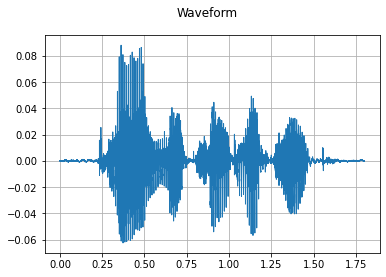

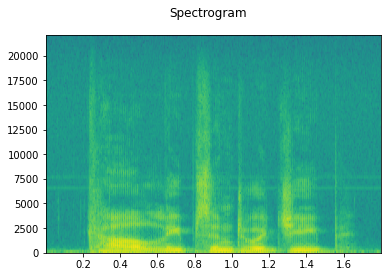

In [25]:
waveform, sample_rate = torchaudio.load(data.iloc[0,0])

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

torch.Size([1, 94815])


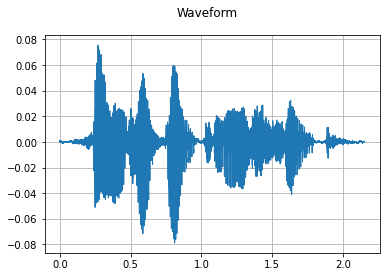

torch.Size([1, 94815])


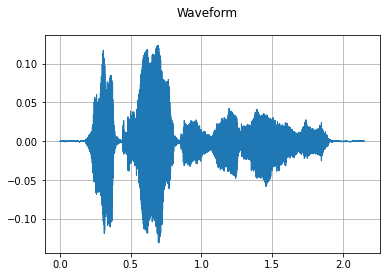

torch.Size([1, 94815])


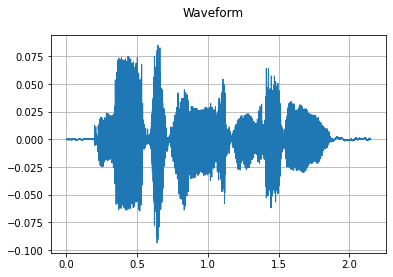

torch.Size([1, 63945])


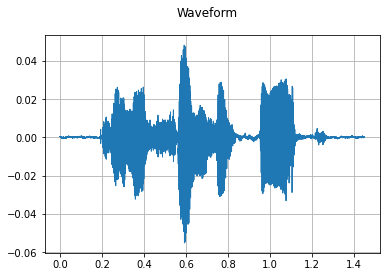

torch.Size([1, 79380])


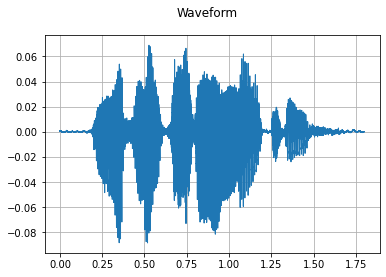

In [41]:
for ind in np.random.choice(list(data.index), 5):
    waveform, sample_rate = torchaudio.load(data.iloc[ind,0])
    print(waveform.shape)
    plot_waveform(waveform, sample_rate)
# data

In [116]:
def resize(waveform, sample_rate, max_s=2):
    num_channels, num_frames = waveform.shape
    max_frames = sample_rate * max_s
    
    if num_frames > max_frames:
        # (max_frames-num_frames)
        waveform = waveform[:,:max_frames]
    
    elif max_frames > num_frames:
        pad_begin_len = np.random.randint(0, max_frames - num_frames)
        pad_end_len = max_frames - num_frames - pad_begin_len
        
        pad_begin = torch.zeros((num_channels, pad_begin_len))
        pad_end = torch.zeros((num_channels, pad_end_len))
        
        waveform = torch.cat((pad_begin, waveform, pad_end), 1)
    
    return waveform
    

In [117]:
def time_shift(waveform, shift_limit):
    _, sig_len = waveform.shape
    shift_amt = int(np.random.random_sample() * shift_limit * sig_len)
    return waveform.roll(shift_amt)

In [118]:
def spectro_gram(waveform, sample_rate, n_mels=64, n_fft=1024, hop_len=None):
    # top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    # spec = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(waveform)

    # Convert to decibels
    # spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
    spec = torchaudio.transforms.MFCC(sample_rate=sample_rate,n_mfcc=64, melkwargs={'n_mels':n_mels, 'n_fft':n_fft})(waveform)
    return spec

In [119]:
def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
        aug_spec = torchaudio.transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
        aug_spec = torchaudio.transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [120]:
class Sounds(Dataset):
  def __init__(self, df):
    self.df = df
    # self.data_path = str(data_path)
    # self.duration = 4000
    # self.sampling_rate = 44100
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    # print(self.df)
    waveform, sample_rate = torchaudio.load(self.df.iloc[idx,0])
    class_id = self.df.iloc[idx,1]
    # audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    # Get the Class ID
    # class_id = self.df.loc[idx, 'classID']

    # aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    # reaud = AudioUtil.resample(aud, self.sr)
    # rechan = AudioUtil.rechannel(reaud, self.channel)
    
    waveform = resize(waveform, sample_rate)
    waveform = time_shift(waveform, self.shift_pct)
    spec = spectro_gram(waveform, sample_rate)
    spec = spectro_augment(spec)
    
    # dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    # shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    # sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    # aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return spec, class_id

In [121]:
# Random split of 80:20 between training and validation
num_items = len(data)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(Sounds(data), [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [122]:
next(iter(train_ds))[0].shape

torch.Size([1, 64, 173])

In [132]:
import torch.nn.functional as F
from torch.nn import init

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (torch.nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
        self.relu1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(16)
        torch.nn.init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = torch.nn.ReLU()
        self.bn4 = torch.nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]
        
        # Fifth Convolution Block
        self.conv5 = torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu5 = torch.nn.ReLU()
        self.bn5 = torch.nn.BatchNorm2d(128)
        init.kaiming_normal_(self.conv5.weight, a=0.1)
        self.conv5.bias.data.zero_()
        conv_layers += [self.conv5, self.relu5, self.bn5]
        
        # Sixth Convolution Block
        self.conv6 = torch.nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu6 = torch.nn.ReLU()
        self.bn6 = torch.nn.BatchNorm2d(256)
        init.kaiming_normal_(self.conv6.weight, a=0.1)
        self.conv6.bias.data.zero_()
        conv_layers += [self.conv6, self.relu6, self.bn6]

        # Linear Classifier
        self.ap = torch.nn.AdaptiveAvgPool2d(output_size=1)
        self.linear_first = torch.nn.Linear(in_features=256, out_features=128 )
        self.linear_first_relu = torch.nn.ReLU()
        self.linear_second = torch.nn.Linear(in_features=128, out_features=64 )
        self.linear_second_relu = torch.nn.ReLU()
        self.linear_third = torch.nn.Linear(in_features=64, out_features=64 )
        self.linear_third_relu = torch.nn.ReLU()
        self.lin = torch.nn.Linear(in_features=64, out_features=5)
        

        # Wrap the Convolutional Blocks
        self.conv = torch.nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.linear_first(x)
        x = self.linear_first_relu(x)
        x = self.linear_second(x)
        x = self.linear_second_relu(x)
        x = self.linear_third(x)
        x = self.linear_third_relu(x)
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device


device(type='cpu')

In [133]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0], data[1]

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        # if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')
  
num_epochs=10   # Just for demo, adjust this higher.
training(myModel, train_dl, num_epochs)

Epoch: 0, Loss: 1.60, Accuracy: 0.23
Epoch: 1, Loss: 1.21, Accuracy: 0.38
Epoch: 2, Loss: 0.99, Accuracy: 0.49
Epoch: 3, Loss: 0.85, Accuracy: 0.57
Epoch: 4, Loss: 0.76, Accuracy: 0.62
Epoch: 5, Loss: 0.73, Accuracy: 0.67
Epoch: 6, Loss: 0.66, Accuracy: 0.70
Epoch: 7, Loss: 0.60, Accuracy: 0.73
Epoch: 8, Loss: 0.57, Accuracy: 0.73
Epoch: 9, Loss: 0.52, Accuracy: 0.76
Finished Training


In [134]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0], data[1]

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(myModel, val_dl)

Accuracy: 0.74, Total items: 240
